## Create DataLoader for VisDrone2019-DET-val


In [44]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader


def get_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def get_annotation(image_path):
  annot_path = image_path[0:image_path.rfind('.')] + '.txt'
  annot_path = annot_path.replace('/images', '/annotations')
  categories = {}

  with open(annot_path) as f:
    for line in f.readlines():
      coords = list(map(int, line.split(',')))
      x, y, w, h, score, category, truncation, occlusion = coords
      categories.setdefault(category, [])
      categories[category].append((x, y, w, h))

  return categories

def show_image(image, annotations=[], title=None, display=True):
  img = image.copy()
  for x, y, w, h in annotations:
    # obj = img[y:y+h, x:x+w]
    img = cv2.rectangle(img, [x, y], [x+w, y+h], color=(255, 0, 0), thickness=4)

  plt.title(title)
  plt.axis('off')
  plt.imshow(img)
  if display:
    plt.show()

def calc_overlap(rect1, rect2):
  (x1, y1, w1, h1), (x2, y2, w2, h2) = rect1, rect2
  x_left, y_top = max(x1, x2), max(y1, y2)
  x_right, y_bottom = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)

  if x_right <= x_left or y_bottom <= y_top:
      return 0.0  # No overlap

  intersection = (x_right - x_left) * (y_bottom - y_top)
  return max(intersection / (w1 * h1), intersection / (w2 * h2))

def add_object(img, obj, y, x):
  h_, w_ = obj.shape[0:2]
  center = (x + w_ // 2, y + h_ // 2)
  mask = None
  return cv2.seamlessClone(obj, img, mask, center, cv2.NORMAL_CLONE)  # or cv2.MIXED_CLONE or cv2.MONOCHROME_TRANSFER

def color_correct(target, reference):
  img = target.astype(np.float32)
  ref = reference.astype(np.float32)
  m1, s1 = np.mean(img, axis=(0, 1)), np.std(img, axis=(0, 1))
  m2, s2 = np.mean(ref, axis=(0, 1)), np.std(ref, axis=(0, 1))
  img = (img - m1) * (s2 / s1) + m2
  return np.clip(img, 0, 255).astype(np.uint8)


def uniform_noise(img, low=-50, high=50):
  noise = np.random.uniform(low, high, img.shape).astype(np.float32)
  noisy = img.astype(np.float32) + noise
  return np.clip(noisy, 0, 255).astype(img.dtype)

def gaussian_noise(img, mean=0, std=50):
  noise = np.random.normal(mean, std, img.shape).astype(np.float32)
  noisy = img.astype(np.float32) + noise
  return np.clip(noisy, 0, 255).astype(img.dtype)


class MyDataset(Dataset):
    labels = {
      0: "ignored regions",
      1: "pedestrian",
      2: "people",
      3: "bicycle",
      4: "car",
      5: "van",
      6: "truck",
      7: "tricycle",
      8: "awning-tricycle",
      9: "bus",
      10: "motor",
      11: "others"
    }

    def __init__(self, dataset_path, size, label, noise_func=None):
        self.size = size
        self.data = []
        self.add_noise = noise_func or (lambda img : img)

        categories = {key : 0 for key in MyDataset.labels.keys()}

        for f in os.scandir(dataset_path+'/images'):
          annotation = get_annotation(f.path)
          for category, values in annotation.items():
            categories[category] += len(values) # dataset stats
          if label in annotation:
            self.data.append((f.path, annotation[label]))

        print("Dataset total :")
        for cat, count in categories.items():
          print(f'{str(cat) : >3} {MyDataset.labels[cat] : <20} {count}')

        assert len(self.data) > 1, "This label has too few samples"

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        i, j = np.random.choice(len(self.data), size=2, replace=False)
        src, dst = self.data[i], self.data[j]
        # place objects from src after transformation to dst
        src_path, annotations = src
        dst_path, _ = dst
        src_img = get_image(src_path)
        dst_img = get_image(dst_path)

        added = []
        for x, y, w, h in annotations:
          obj = src_img[y:y+h, x:x+w]

          scale = np.random.uniform(0.8, 1.2)
          h_, w_ = [int(i * scale) for i in obj.shape[0:2]]
          obj = cv2.resize(obj, [w_, h_], interpolation=cv2.INTER_AREA)

          for _ in range(30): # number of tries to place object without overlap > 50%
            y, x = [int(np.random.uniform(0, dst_img.shape[i] - obj.shape[i])) for i in [0, 1]]
            if all(calc_overlap(rect, (x, y, w_, h_)) < 0.5 for rect in added):
              break

          added.append((x, y, w_, h_))
          dst_img = add_object(dst_img, obj, y, x)

        # Plot src and edited dst image
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        show_image(dst_img, annotations=added, title=f'Placed {len(added)} objects', display=False)

        noisy = self.add_noise(dst_img)
        plt.subplot(1, 2, 2)
        show_image(noisy, title=f'Noisy', display=False)

        plt.tight_layout()
        plt.show()
        return dst_img, noisy


dataset = MyDataset('drive/MyDrive/VisDrone2019-DET-val', size=2, label=4, noise_func=gaussian_noise)
loader = DataLoader(dataset)

Dataset total :
  0 ignored regions      20
  1 pedestrian           206
  2 people               224
  3 bicycle              21
  4 car                  249
  5 van                  12
  6 truck                1
  7 tricycle             34
  8 awning-tricycle      35
  9 bus                  0
 10 motor                308
 11 others               0


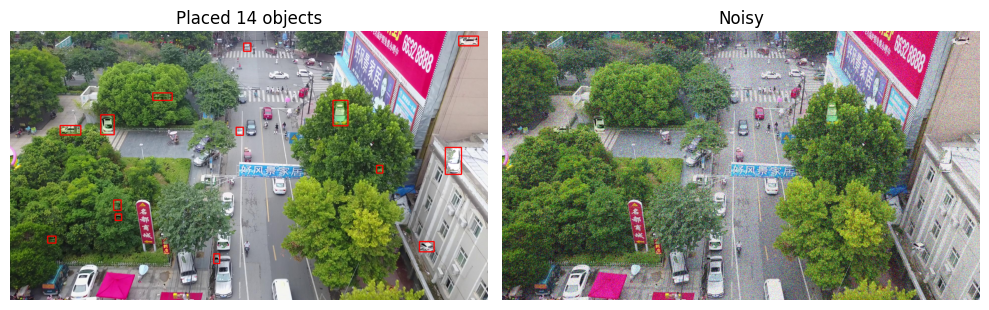

Denoiser   Metrics    Value
Median
	Time 	 0.022
	MSE  	 362.102
	SSIM 	 0.464
Gauss
	Time 	 0.010
	MSE  	 300.412
	SSIM 	 0.554
Bilateral
	Time 	 0.342
	MSE  	 788.361
	SSIM 	 0.358
NLM
	Time 	 7.598
	MSE  	 1798.125
	SSIM 	 0.269


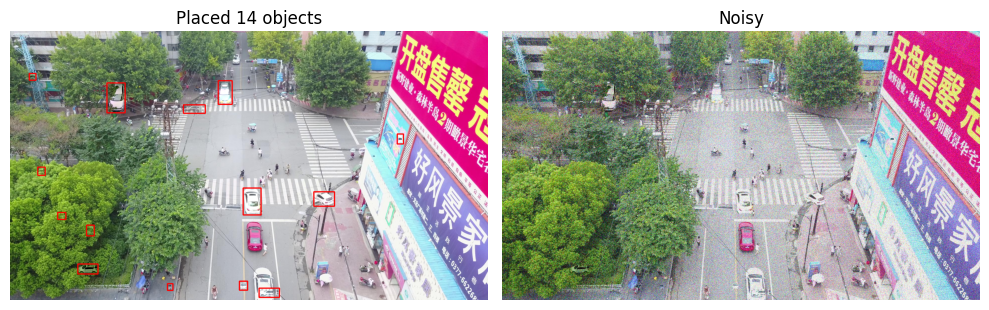

Denoiser   Metrics    Value
Median
	Time 	 0.021
	MSE  	 347.835
	SSIM 	 0.468
Gauss
	Time 	 0.005
	MSE  	 312.223
	SSIM 	 0.546
Bilateral
	Time 	 0.314
	MSE  	 759.856
	SSIM 	 0.359
NLM
	Time 	 6.834
	MSE  	 1493.019
	SSIM 	 0.336


In [45]:
import time
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim

def estimate_denoising(filter, orig, noisy):
  start = time.time()
  filtered = filter(noisy)
  elapsed = (time.time() - start)
  return {'Time' : elapsed,
          'MSE' : mse(orig, filtered),
          'SSIM' : ssim(orig, filtered, channel_axis=-1)}

filters = {
  'Median'    : (lambda x : cv2.medianBlur(x, 5)),
  'Gauss'     : (lambda x : cv2.GaussianBlur(x, (5, 5), 1.0)),
  'Bilateral' : (lambda x : cv2.bilateralFilter(x, 9, 75, 75)),
  'NLM'       : (lambda x : cv2.fastNlMeansDenoisingColored(x, None, 10, 10, 7, 21)),
}

for orig, noisy in loader:
  orig = orig[0].numpy().astype(np.uint8)
  noisy = noisy[0].numpy().astype(np.uint8)

  print('Denoiser   Metrics    Value')
  for name, filter in filters.items():
    print(name)
    for metric, value in estimate_denoising(filter, orig, noisy).items():
      print(f'\t{metric : <5}\t{value : .3f}')